# Using LittleVGG for Emotion Detection

### Training Emotion Detector

In [ ]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1

In [ ]:
## initializing 

In [ ]:
!pip install -q kaggle

In [ ]:
 from google.colab import files
 import numpy as np
 import cv2

##Downloading Dataset from Kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amzzee","key":"bb675292b577766dac28e58415be0b38"}'}

In [ ]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                               title                                                 size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
heeraldedhia/groceries-dataset                                    Groceries dataset                                    257KB  2020-09-17 04:36:08            197  
andrewmvd/trip-advisor-hotel-reviews                              Trip Advisor Hotel Reviews                             5MB  2020-09-30 08:31:20             56  
balraj98/stanford-background-dataset                              Stanford Background Dataset                           17MB  2020-09-26 12:57:59             13  
nehaprabhavalkar/indian-food-101                                  Indian Food 101                                        7KB  2020-09-30 06:23:43            155  
jilkothari/finance-acc

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 47% 9.00M/19.3M [00:02<00:02, 4.30MB/s]
100% 19.3M/19.3M [00:03<00:00, 6.71MB/s]
 92% 85.0M/92.0M [00:04<00:00, 12.6MB/s]
100% 92.0M/92.0M [00:04<00:00, 22.0MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.05MB/s]
 93% 90.0M/96.6M [00:03<00:00, 21.5MB/s]
100% 96.6M/96.6M [00:03<00:00, 28.0MB/s]
 94% 73.0M/77.3M [00:04<00:00, 16.4MB/s]
100% 77.3M/77.3M [00:04<00:00, 19.9MB/s]


In [ ]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 512

In [ ]:
import tarfile
tf = tarfile.open("/content/fer2013.tar.gz")
tf.extractall()

In [ ]:
output_path =  "/content/ferdata"

if os.path.exists(output_path):
    os.system('rm -rf {}'.format(output_path))

os.system('mkdir {}'.format(output_path))

label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

data = np.genfromtxt('/content/fer2013/fer2013.csv',delimiter=',',dtype=None, encoding=None)
labels = data[1:,0].astype(np.int32)
image_buffer = data[1:,1]
images = np.array([np.fromstring(image, np.uint8, sep=' ') for image in image_buffer])
usage = data[1:,2]
dataset = zip(labels, images, usage)
usage_path = ""
for i, d in enumerate(dataset):
    if(d[-1] == "Training" or d[-1] == "PrivateTest"):
        usage_path = os.path.join(output_path, "Training")
    else:
        usage_path = os.path.join(output_path, d[-1])

    label_path = os.path.join(usage_path, label_names[d[0]])
    img = d[1].reshape((48,48))
    img_name = '%08d.jpg' % i
    img_path = os.path.join(label_path, img_name)
    if not os.path.exists(usage_path):
        os.system('mkdir {}'.format(usage_path))
    if not os.path.exists(label_path):
        os.system('mkdir {}'.format(label_path))
    cv2.imwrite(img_path, img)

In [ ]:
train_data_dir = '/content/ferdata/Training'
validation_data_dir = '/content/ferdata/PublicTest'

In [ ]:

val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
        rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')



Found 32298 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
print(validation_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [ ]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0

## Training our model

In [ ]:
filepath = os.path.join("/content/Expression/model_v6_{epoch}.hdf5")


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
nb_train_samples = 32298
nb_validation_samples = 3589
epochs = 150
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# model.save_weights('model.h5')


Epoch 1/150
63/63 [==============================] - ETA: 0s - loss: 1.4257 - accuracy: 0.4628
Epoch 00001: val_accuracy improved from -inf to 0.49721, saving model to /content/Expression/model_v6_1.hdf5
63/63 [==============================] - 27s 430ms/step - loss: 1.4257 - accuracy: 0.4628 - val_loss: 1.3643 - val_accuracy: 0.4972
Epoch 2/150
63/63 [==============================] - ETA: 0s - loss: 1.4223 - accuracy: 0.4653
Epoch 00002: val_accuracy improved from 0.49721 to 0.50335, saving model to /content/Expression/model_v6_2.hdf5
63/63 [==============================] - 27s 432ms/step - loss: 1.4223 - accuracy: 0.4653 - val_loss: 1.3559 - val_accuracy: 0.5033
Epoch 3/150
63/63 [==============================] - ETA: 0s - loss: 1.4201 - accuracy: 0.4700
Epoch 00003: val_accuracy did not improve from 0.50335
63/63 [==============================] - 27s 424ms/step - loss: 1.4201 - accuracy: 0.4700 - val_loss: 1.3622 - val_accuracy: 0.5003
Epoch 4/150
63/63 [========================

In [ ]:
model.save_weights('/content/model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


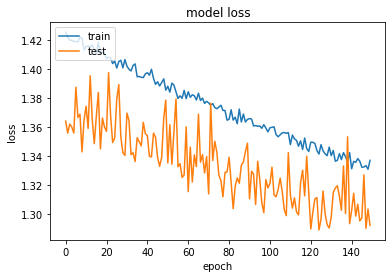

In [ ]:
print(model_info.history.keys())

import matplotlib.pyplot as plt
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights("/content/Expression/model_v6_125.hdf5")

Found 3589 images belonging to 7 classes.
Confusion Matrix
[[200   0  29  46  67 105  20]
 [ 25   0   6   5   7  12   1]
 [ 72   0  79  41  98 132  74]
 [ 41   0  24 707  66  35  22]
 [ 48   0  32  62 339 120   6]
 [ 75   0  51  58 162 294  13]
 [ 30   0  34  25  28  16 282]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.41      0.43      0.42       467
     Disgust       0.00      0.00      0.00        56
        Fear       0.31      0.16      0.21       496
       Happy       0.75      0.79      0.77       895
     Neutral       0.44      0.56      0.49       607
         Sad       0.41      0.45      0.43       653
    Surprise       0.67      0.68      0.68       415

    accuracy                           0.53      3589
   macro avg       0.43      0.44      0.43      3589
weighted avg       0.51      0.53      0.52      3589



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


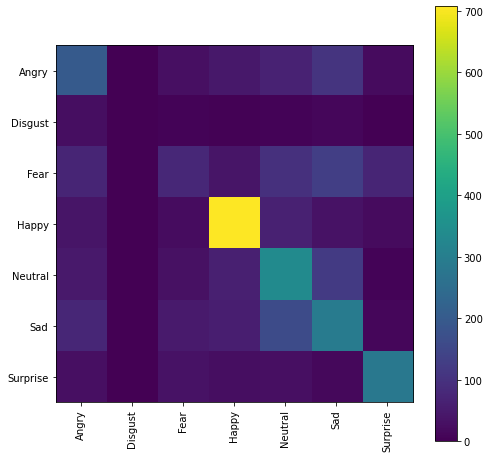

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


nb_train_samples = 28709
nb_validation_samples = 3589

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Loading our saved model

In [2]:
from keras.models import load_model

classifier = load_model('/content/Expressions/model_v6_125.hdf5')

class labels

In [ ]:
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

###validation images

In [ ]:
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


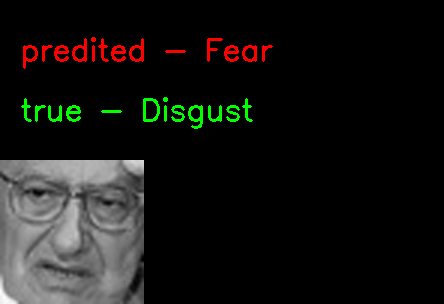

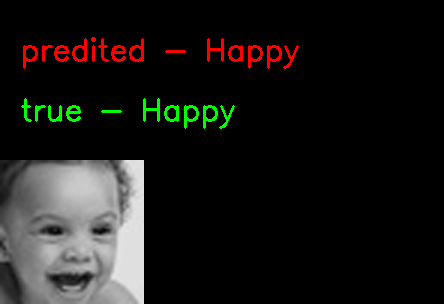

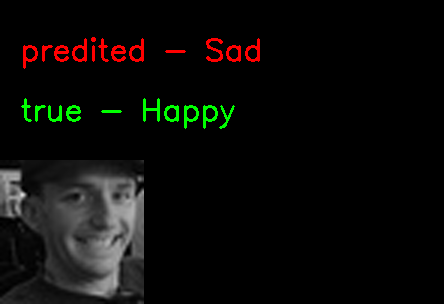

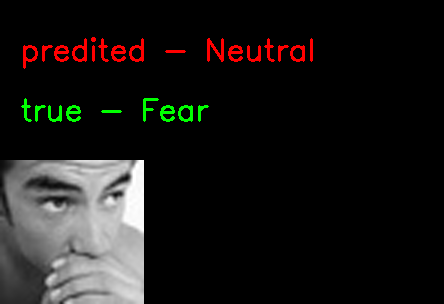

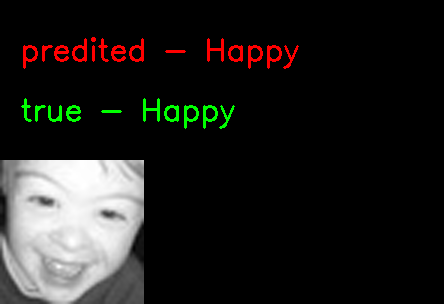

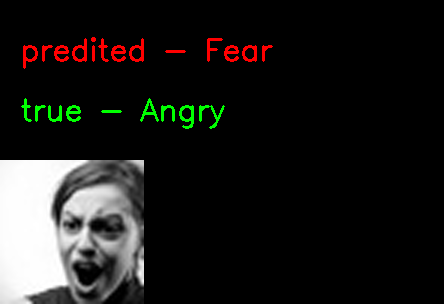

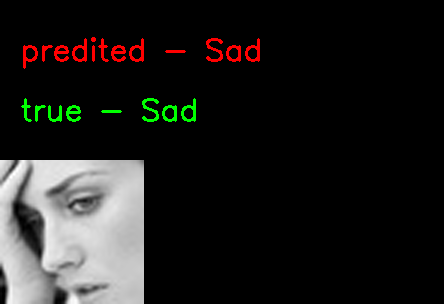

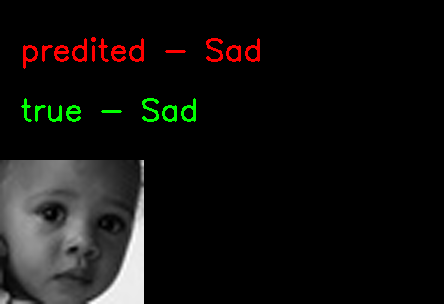

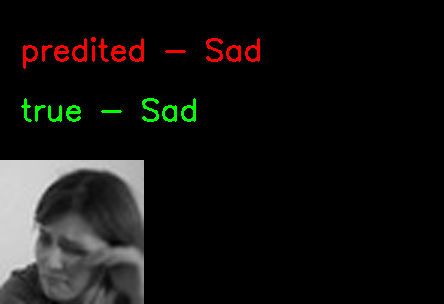

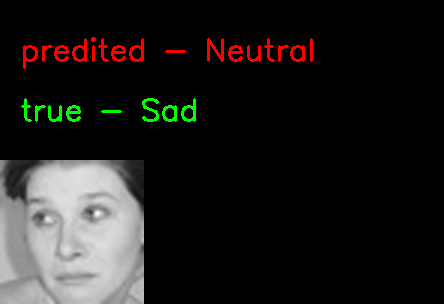

In [ ]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2_imshow(expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = '/content/ferdata/PublicTest/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

###single image test

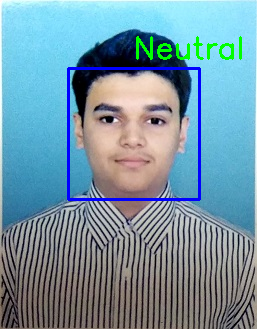

In [6]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow
class_labels={0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("/content/Abdul_Mannan_Zafar_photo.jpeg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    
cv2_imshow(image)
cv2.waitKey(0)

cv2.destroyAllWindows()